# **Download Libraries**

In [ ]:
!pip install tensorboardX
!pip install -q evaluate seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.

# **Import libraries**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as utils
import torchvision
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from datetime import datetime
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import cv2
import math
import os
import numpy as np
from tqdm.auto import tqdm
import evaluate
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# **Build Attention ResNet**

## **Attention layers**

In [ ]:
class ProjectorBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(ProjectorBlock, self).__init__()
        self.op = nn.Conv2d(in_channels=in_features, out_channels=out_features,
            kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        return self.op(x)

class SpatialAttn(nn.Module):
    def __init__(self, in_features, normalize_attn=True):
        super(SpatialAttn, self).__init__()
        self.normalize_attn = normalize_attn
        self.op = nn.Conv2d(in_channels=in_features, out_channels=1,
            kernel_size=1, padding=0, bias=False)

    def forward(self, l, g):
        N, C, H, W = l.size()
        c = self.op(l+g) # (batch_size,1,H,W)
        if self.normalize_attn:
            a = F.softmax(c.view(N,1,-1), dim=2).view(N,1,H,W)
        else:
            a = torch.sigmoid(c)
        g = torch.mul(a.expand_as(l), l)
        if self.normalize_attn:
            g = g.view(N,C,-1).sum(dim=2) # (batch_size,C)
        else:
            g = F.adaptive_avg_pool2d(g, (1,1)).view(N,C)
        return c.view(N,1,H,W), g

## **Residual block**

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

## **Build the network**

In [ ]:
class AttnResNet(nn.Module):
    def __init__(self, sample_size, block, layers, num_classes, attention=True, normalize_attn=True):
        super(AttnResNet, self).__init__()
        # conv blocks
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 512, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(5, stride=2)
        self.dense = nn.Conv2d(in_channels=512, out_channels=512, kernel_size= 1, padding=0, bias=True)
        # attention blocks
        self.attention = attention
        if self.attention:
            self.projector = ProjectorBlock(128, 512)
            self.attn1 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
            self.attn2 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
            self.attn3 = SpatialAttn(in_features=512, normalize_attn=normalize_attn)
        # final classification layer
        if self.attention:
            self.classify = nn.Linear(in_features=512*3, out_features=num_classes, bias=True)
        else:
            self.classify = nn.Linear(in_features=512, out_features=num_classes, bias=True)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)

        x = self.layer0(x)

        l1 = self.layer1(x)

        l2 = self.layer2(l1)

        l3 = self.layer3(l2)

        x = self.avgpool(l3)

        #x = x.view(x.size(0), -1)

        g = self.dense(x) # batch_sizex512x1x1
        # attention
        if self.attention:
            c1, g1 = self.attn1(self.projector(l1), g)
            c2, g2 = self.attn2(l2, g)
            c3, g3 = self.attn3(l3, g)
            g = torch.cat((g1,g2,g3), dim=1) # batch_sizex3C
            # classification layer
            x = self.classify(g) # batch_sizexnum_classes
        else:
            c1, c2, c3 = None, None, None
            x = self.classify(torch.squeeze(g))
        return [x, c1, c2, c3]

## **Train / Val epochs**

In [ ]:
def train_epoch(model, criterion, optimizer, dataloader, device, epoch, log_interval, writer):
    model.train()
    losses = []
    all_label = []
    all_pred = []

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        # get the inputs and labels
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        if isinstance(outputs, list):
            outputs = outputs[0]

        # compute the loss
        loss = criterion(outputs, labels.squeeze())
        losses.append(loss.item())

        # compute the accuracy
        prediction = torch.max(outputs, 1)[1]
        all_label.extend(labels.squeeze())
        all_pred.extend(prediction)
        score = accuracy_score(labels.squeeze().cpu().data.squeeze().numpy(), prediction.cpu().data.squeeze().numpy())

        # backward & optimize
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % log_interval == 0:
            print("epoch {:3d} | iteration {:5d} | Loss {:.6f} | Acc {:.2f}%".format(epoch+1, batch_idx+1, loss.item(), score*100))
    # Compute the average loss & accuracy
    training_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)
    training_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())
    # Log
    writer.add_scalars('Loss', {'train': training_loss}, epoch+1)
    writer.add_scalars('Accuracy', {'train': training_acc}, epoch+1)
    print("Average Training Loss of Epoch {}: {:.6f} | Acc: {:.2f}%".format(epoch+1, training_loss, training_acc*100))
    return {'train_loss' : training_loss, 'train_acc' : training_acc}


def val_epoch(model, criterion, dataloader, device, epoch, writer):
    model.eval()
    losses = []
    all_label = []
    all_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            # get the inputs and labels
            inputs, labels = inputs.to(device), labels.to(device)
            # forward
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[0]
            # compute the loss
            loss = criterion(outputs, labels.squeeze())
            losses.append(loss.item())
            # collect labels & prediction
            prediction = torch.max(outputs, 1)[1]
            all_label.extend(labels.squeeze())
            all_pred.extend(prediction)

    # Compute the average loss & accuracy
    val_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)
    val_acc = accuracy_score(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy())
    # Log
    writer.add_scalars('Loss', {'val': val_loss}, epoch+1)
    writer.add_scalars('Accuracy', {'val': val_acc}, epoch+1)
    print("Average Validation Loss: {:.6f} | Acc: {:.2f}%".format(val_loss, val_acc*100))
    return {'val_loss' : val_loss, 'val_acc' : val_acc}

# **Import dataset**

In [ ]:
#train and test data directory
data_dir = "/gdrive/MyDrive/data/train_attention_resnet_all/train/"
test_data_dir = "/gdrive/MyDrive/data/train_attention_resnet_all/test/"

#load the train and test data with augmentation
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),

]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
]))

In [ ]:
batch_size = 5
val_size = 500
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
#load the train and validation into batches.
train_loader = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

Length of Train Data : 4012
Length of Validation Data : 500


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# switch to cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# **Let's train !**

In [ ]:
# Create model
model = AttnResNet(sample_size=32, block = ResidualBlock, layers = [3, 4, 6, 3], num_classes=6).to(device)
if torch.cuda.device_count() > 1:
    print("Using {} GPUs".format(torch.cuda.device_count()))
    model = nn.DataParallel(model)

In [ ]:
writer = SummaryWriter("runs/resnet_attention_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now()))

In [ ]:
num_epochs = 9
lr = 1e-4
no_save = True
log_interval = 100
weight_decay = 1e-4
save_path = "/gdrive/MyDrive/saved_models/resnet_all/"

In [ ]:
os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

In [ ]:
# took

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
history = {"train_loss" : [], "train_accuracy" : [], "val_loss" : [], "val_accuracy" : []}


for epoch in range(num_epochs):
    train_hist = train_epoch(model, criterion, optimizer, train_loader, device, epoch, log_interval, writer)
    history["train_loss"].append(train_hist["train_loss"])
    history["train_accuracy"].append(train_hist["train_acc"])
    val_hist = val_epoch(model, criterion, val_loader, device, epoch, writer)
    history["val_loss"].append(val_hist['val_loss'])
    history["val_accuracy"].append(val_hist['val_acc'])

    # adjust learning rate
    # scheduler.step()
    if not no_save:
        torch.save(model.state_dict(), os.path.join(save_path, "cnn_epoch{:03d}.pth".format(epoch+1)))
        print("Saving Model of Epoch {}".format(epoch+1))


epoch   1 | iteration   100 | Loss 1.619124 | Acc 40.00%
epoch   1 | iteration   200 | Loss 1.314272 | Acc 40.00%
epoch   1 | iteration   300 | Loss 1.055056 | Acc 80.00%
epoch   1 | iteration   400 | Loss 1.142042 | Acc 40.00%
epoch   1 | iteration   500 | Loss 0.566547 | Acc 100.00%
epoch   1 | iteration   600 | Loss 1.176497 | Acc 60.00%
epoch   1 | iteration   700 | Loss 0.223026 | Acc 100.00%
epoch   1 | iteration   800 | Loss 1.064219 | Acc 60.00%
Average Training Loss of Epoch 1: 1.098582 | Acc: 60.57%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 0.905172 | Acc: 72.00%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   2 | iteration   100 | Loss 0.502675 | Acc 80.00%
epoch   2 | iteration   200 | Loss 0.173047 | Acc 100.00%
epoch   2 | iteration   300 | Loss 0.317046 | Acc 100.00%
epoch   2 | iteration   400 | Loss 0.949429 | Acc 80.00%
epoch   2 | iteration   500 | Loss 0.253608 | Acc 100.00%
epoch   2 | iteration   600 | Loss 0.123931 | Acc 100.00%
epoch   2 | iteration   700 | Loss 0.050543 | Acc 100.00%
epoch   2 | iteration   800 | Loss 0.189938 | Acc 100.00%
Average Training Loss of Epoch 2: 0.489648 | Acc: 84.17%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 1.294433 | Acc: 57.40%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   3 | iteration   100 | Loss 0.709304 | Acc 80.00%
epoch   3 | iteration   200 | Loss 0.060880 | Acc 100.00%
epoch   3 | iteration   300 | Loss 0.394095 | Acc 80.00%
epoch   3 | iteration   400 | Loss 0.098155 | Acc 100.00%
epoch   3 | iteration   500 | Loss 0.110694 | Acc 100.00%
epoch   3 | iteration   600 | Loss 0.154211 | Acc 100.00%
epoch   3 | iteration   700 | Loss 0.596424 | Acc 80.00%
epoch   3 | iteration   800 | Loss 0.049753 | Acc 100.00%
Average Training Loss of Epoch 3: 0.347308 | Acc: 88.73%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 0.306262 | Acc: 90.80%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   4 | iteration   100 | Loss 0.048298 | Acc 100.00%
epoch   4 | iteration   200 | Loss 0.446146 | Acc 100.00%
epoch   4 | iteration   300 | Loss 0.676843 | Acc 80.00%
epoch   4 | iteration   400 | Loss 0.006330 | Acc 100.00%
epoch   4 | iteration   500 | Loss 0.479496 | Acc 80.00%
epoch   4 | iteration   600 | Loss 0.166216 | Acc 100.00%
epoch   4 | iteration   700 | Loss 0.056348 | Acc 100.00%
epoch   4 | iteration   800 | Loss 0.038147 | Acc 100.00%
Average Training Loss of Epoch 4: 0.259111 | Acc: 91.15%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 0.320059 | Acc: 88.40%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   5 | iteration   100 | Loss 0.012086 | Acc 100.00%
epoch   5 | iteration   200 | Loss 0.025774 | Acc 100.00%
epoch   5 | iteration   300 | Loss 1.065466 | Acc 80.00%
epoch   5 | iteration   400 | Loss 0.322949 | Acc 80.00%
epoch   5 | iteration   500 | Loss 0.061299 | Acc 100.00%
epoch   5 | iteration   600 | Loss 0.757013 | Acc 60.00%
epoch   5 | iteration   700 | Loss 0.107921 | Acc 100.00%
epoch   5 | iteration   800 | Loss 0.149925 | Acc 100.00%
Average Training Loss of Epoch 5: 0.210800 | Acc: 93.10%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 0.342409 | Acc: 91.00%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   6 | iteration   100 | Loss 0.155423 | Acc 80.00%
epoch   6 | iteration   200 | Loss 0.221665 | Acc 80.00%
epoch   6 | iteration   300 | Loss 0.770809 | Acc 80.00%
epoch   6 | iteration   400 | Loss 0.005796 | Acc 100.00%
epoch   6 | iteration   500 | Loss 0.157419 | Acc 100.00%
epoch   6 | iteration   600 | Loss 0.963355 | Acc 80.00%
epoch   6 | iteration   700 | Loss 0.127673 | Acc 100.00%
epoch   6 | iteration   800 | Loss 0.145710 | Acc 100.00%
Average Training Loss of Epoch 6: 0.190789 | Acc: 93.74%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 2.474622 | Acc: 45.80%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   7 | iteration   100 | Loss 0.030508 | Acc 100.00%
epoch   7 | iteration   200 | Loss 0.081862 | Acc 100.00%
epoch   7 | iteration   300 | Loss 0.138839 | Acc 100.00%
epoch   7 | iteration   400 | Loss 0.002073 | Acc 100.00%
epoch   7 | iteration   500 | Loss 0.002899 | Acc 100.00%
epoch   7 | iteration   600 | Loss 0.005049 | Acc 100.00%
epoch   7 | iteration   700 | Loss 0.083359 | Acc 100.00%
epoch   7 | iteration   800 | Loss 0.669787 | Acc 80.00%
Average Training Loss of Epoch 7: 0.156700 | Acc: 94.84%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 0.311509 | Acc: 89.80%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   8 | iteration   100 | Loss 0.001355 | Acc 100.00%
epoch   8 | iteration   200 | Loss 0.025974 | Acc 100.00%
epoch   8 | iteration   300 | Loss 0.001389 | Acc 100.00%
epoch   8 | iteration   400 | Loss 0.313212 | Acc 80.00%
epoch   8 | iteration   500 | Loss 0.010567 | Acc 100.00%
epoch   8 | iteration   600 | Loss 0.050180 | Acc 100.00%
epoch   8 | iteration   700 | Loss 0.046351 | Acc 100.00%
epoch   8 | iteration   800 | Loss 0.001486 | Acc 100.00%
Average Training Loss of Epoch 8: 0.132111 | Acc: 95.84%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 0.417668 | Acc: 88.40%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


epoch   9 | iteration   100 | Loss 0.020479 | Acc 100.00%
epoch   9 | iteration   200 | Loss 0.006030 | Acc 100.00%
epoch   9 | iteration   300 | Loss 0.043862 | Acc 100.00%
epoch   9 | iteration   400 | Loss 0.104907 | Acc 100.00%
epoch   9 | iteration   500 | Loss 0.059383 | Acc 100.00%
epoch   9 | iteration   600 | Loss 0.010285 | Acc 100.00%
epoch   9 | iteration   700 | Loss 0.007393 | Acc 100.00%
epoch   9 | iteration   800 | Loss 0.002031 | Acc 100.00%
Average Training Loss of Epoch 9: 0.125201 | Acc: 95.66%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average Validation Loss: 0.190106 | Acc: 93.20%


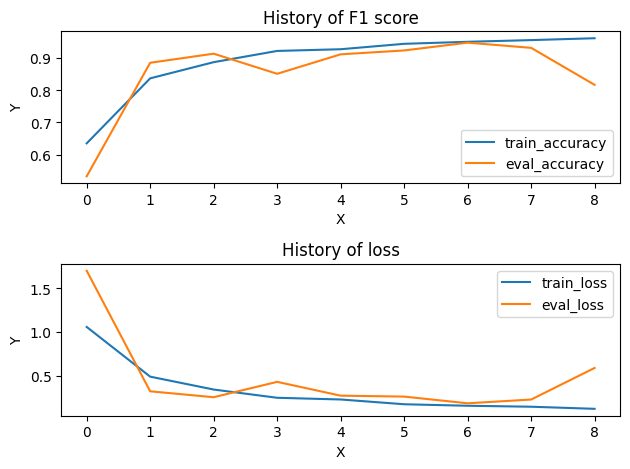

In [ ]:
# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(2)

# Plot lines on the first subplot
ax1.plot(history["train_accuracy"], label='train_accuracy')
ax1.plot(history["val_accuracy"], label='eval_accuracy')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('History of F1 score')
ax1.legend()

# Plot lines on the second subplot
ax2.plot(history["train_loss"], label='train_loss')
ax2.plot(history["val_loss"], label='eval_loss')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('History of loss')
ax2.legend()

# Adjust the layout of the subplots
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
torch.cuda.empty_cache()

## **Save the model**

In [ ]:
torch.save(model, "/gdrive/MyDrive/saved_models/resNet/resnet_all_model_state_4.pth")

In [ ]:
modelB = torch.load("/gdrive/MyDrive/saved_models/resNet/resnet_all_model_state_2.pth", map_location=device)

In [ ]:
torch.save(model.state_dict(), "/gdrive/MyDrive/saved_models/resNet/resnet_all_model_state_dict_metrics.pth")

In [ ]:
model_ = AttnResNet(sample_size=32, block = ResidualBlock, layers = [3, 4, 6, 3], num_classes=6).to(device)
model_.load_state_dict(torch.load("/gdrive/MyDrive/saved_models/resNet/resnet_all_model_state_dict2.pth", map_location=device), strict=False)

<All keys matched successfully>

# **Evaluation**

In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 10
lr = 1e-4
no_save = False
log_interval = 100
weight_decay = 1e-4
optimizer = optim.Adam(modelB.parameters(), lr=lr, weight_decay=weight_decay)
writer = SummaryWriter("runs/resnet_attention_{:%Y-%m-%d_%H-%M-%S}".format(datetime.now()))

In [ ]:
def evaluate_model(model, criterion, dataloader, device,  writer):
    model.eval()
    losses = []
    all_label = []
    all_pred = []

    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(dataloader):
            # get the inputs and labels
            inputs, labels = inputs.to(device), labels.to(device)
            # forward
            outputs = model(inputs)
            if isinstance(outputs, list):
                outputs = outputs[0]
            # compute the loss
            loss = criterion(outputs, labels.squeeze())
            losses.append(loss.item())
            # collect labels & prediction
            prediction = torch.max(outputs, 1)[1]
            all_label.extend(labels.squeeze())
            all_pred.extend(prediction)

    # Compute the average loss & accuracy
    val_loss = sum(losses)/len(losses)
    all_label = torch.stack(all_label, dim=0)
    all_pred = torch.stack(all_pred, dim=0)

    # Classification report
    print('\n\n\t\tCLASSIFICATIION METRICS\n')
    print(metrics.classification_report(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy(),
                                        target_names = ["handwritten", "id", "invoice", "receipt", "resume", "table"]))
    return metrics.classification_report(all_label.squeeze().cpu().data.squeeze().numpy(), all_pred.cpu().data.squeeze().numpy(),
                                        target_names = ["handwritten", "id", "invoice", "receipt", "resume", "table"], output_dict=True)

In [ ]:
report = evaluate_model(modelB, criterion, test_loader, device, writer)
df = pd.DataFrame(report).transpose()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(




		CLASSIFICATIION METRICS

              precision    recall  f1-score   support

 handwritten       0.95      0.95      0.95       186
          id       0.93      0.94      0.93       197
     invoice       0.97      0.90      0.93       201
     receipt       0.98      0.88      0.92       194
      resume       0.84      0.99      0.91       179
       table       0.89      0.89      0.89       171

    accuracy                           0.93      1128
   macro avg       0.93      0.93      0.93      1128
weighted avg       0.93      0.93      0.93      1128



In [ ]:
from sklearn.metrics import roc_auc_score

def eval_model_pred(model, dataloaders):
    all_pred = []
    all_label = []

    model.eval()   # Set model to evaluate mode

    # Iterate over data.
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        outputs = model(inputs)[0]
        prediction = torch.max(outputs, 1)[1]

        all_pred.extend(prediction)
        all_label.extend(labels.cpu().numpy())

    return all_label, all_pred

original_labels, all_pred = eval_model_pred(modelB, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(torch.Tensor(original_labels).cpu(), torch.Tensor(all_pred).cpu())
classes = ["handwritten", "id", "invoice", "receipt", "resume", "table"]
specificity = {}


for i in range(len(cm)):
    tn = np.sum(np.delete(np.delete(cm, i, 0), i, 1))
    fp = np.sum(cm[:, i]) - cm[i, i]
    specificity[classes[i]] = tn / (tn + fp)
specificity_values = list(specificity.values())
macro_avg_specificity = sum(specificity_values) / len(specificity_values)

print("Macro Average Specificity:", macro_avg_specificity)
print(specificity)


Macro Average Specificity: 0.9851792550609483
{'handwritten': 0.9904458598726115, 'id': 0.9838882921589689, 'invoice': 0.9946062567421791, 'receipt': 0.9957173447537473, 'resume': 0.9652265542676501, 'table': 0.9811912225705329}


In [ ]:
print('\t\tCLASSIFICATIION METRICS\n\tCNN with attention mechanism for pipeline ')
print('______________________________________________________')
df

		CLASSIFICATIION METRICS
	CNN with attention mechanism for pipeline 
______________________________________________________


,precision,recall,f1-score,support
handwritten,0.980000,0.918750,0.948387,160.000000
id,0.928571,0.994118,0.960227,170.000000
invoice,0.924528,0.918750,0.921630,160.000000
receipt,0.992481,0.795181,0.882943,166.000000
resume,0.800000,0.971751,0.877551,177.000000
table,0.891156,0.856209,0.873333,153.000000
accuracy,0.910751,0.910751,0.910751,0.910751
macro avg,0.919456,0.909126,0.910679,986.000000
weighted avg,0.918134,0.910751,0.910706,986.000000


# **Inference**

In [ ]:
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

In [ ]:
def predict_img_class(img,model):
    classes = ["handwritten", "id", "invoice", "receipt", "resume", "table"]
    model.eval()
    img = to_device(img.unsqueeze(0), device)
    logs =  model(img)[0]
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(logs)
    classe = torch.argmax(probs, 1)
    return classes[classe]


**Number of errors**

*   Handwriting -> 0/9
*   Id          -> 3/9
*   Invoice     -> 0/7
*   Receipt     -> 2/7
*   Resume      -> 0/7
*   Table       -> 0/7

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


_3
* handwriting 0/9
* id 4/9, 2/5
* invoice 0/7, 0/5
* receipt 1/7, 5/8
* resume 0/7
* table 0/7


In [ ]:
from PIL import Image
import numpy as np
import time
#open image file
img = Image.open("/gdrive/MyDrive/test_images/table7.jpg")

#resize image
img = img.resize((150,150))

channels = transforms.ToTensor()(img)
if channels.shape[0]>3 or channels.shape[0]<3:
  img = img.convert(mode='RGB')

#convert image to tensor
img = transforms.ToTensor()(img)

#print image
#plt.imshow(img.permute(1,2,0))

start_time = time.time()
classe = predict_img_class(img, modelB)
end_time = time.time()

#prdict image label
print(f"Predicted Class : {classe}\nexecution time {end_time - start_time}")

Predicted Class : invoice
execution time 0.03122711181640625
